In [11]:
import seaborn as sns
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


In [12]:

df = pd.read_csv('../input/movielens-100k-dataset/ml-100k/u.data', sep='\t',
                 names=['user_id','item_id','rating','tstamp']).sample(frac=1)
df['date'] = pd.to_datetime(df['tstamp'],unit='s')

print(df.head())
items = pd.read_csv('../input/movielens-100k-dataset/ml-100k/u.item', sep='|',
                    names=['movie id' ,'movie title' ,'release date' ,'video release date' ,
                           'IMDb URL' ,'unknown' ,'Action' ,'Adventure' ,'Animation' ,
                           'Children' ,'Comedy' ,'Crime' ,'Documentary' ,'Drama' ,'Fantasy' ,
                           'Film-Noir' ,'Horror' ,'Musical' ,'Mystery' ,'Romance' ,'Sci-Fi' ,
                           'Thriller' ,'War' ,'Western'],encoding='latin')
def get_year(x):
    if pd.isna(x):
        return 0
    else:
        return(int(x[-4:]))
items['year'] = items['release date'].apply(get_year)
items = items.set_index('movie id')
print(items.head)
num_users = len(pd.unique(df['user_id']))
num_movie = len(pd.unique(df['item_id']))

       user_id  item_id  rating     tstamp                date
23329       13      313       4  882774047 1997-12-22 07:00:47
17628      328      164       3  885047484 1998-01-17 14:31:24
4954        49       72       2  888069246 1998-02-21 13:54:06
20024      452       61       1  887718917 1998-02-17 12:35:17
82335      567       79       2  882427023 1997-12-18 06:37:03
<bound method NDFrame.head of                                         movie title release date  \
movie id                                                           
1                                  Toy Story (1995)  01-Jan-1995   
2                                  GoldenEye (1995)  01-Jan-1995   
3                                 Four Rooms (1995)  01-Jan-1995   
4                                 Get Shorty (1995)  01-Jan-1995   
5                                    Copycat (1995)  01-Jan-1995   
...                                             ...          ...   
1678                              Mat' i syn (19

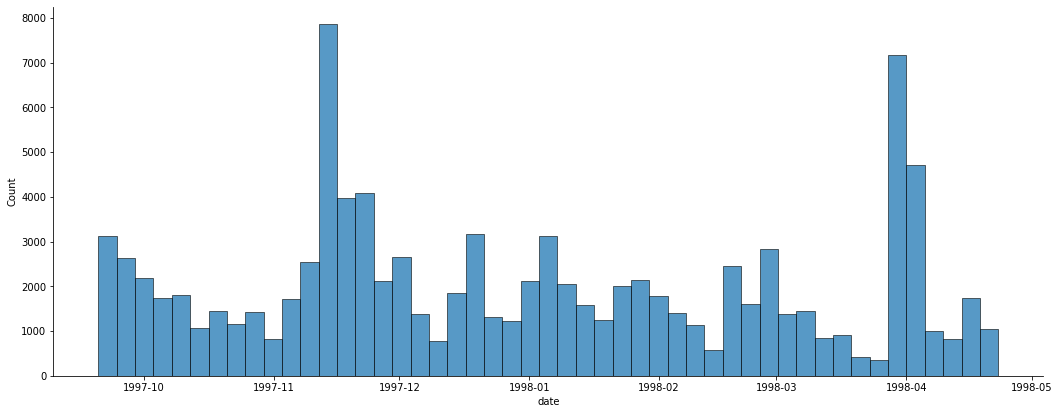

In [24]:
g = sns.displot(df['date'])
g.fig.set_figheight(6)
g.fig.set_figwidth(18)

In [35]:
#Date based split
# cutoff_date = '1998-03-01'
# df_train = df[df['date'] < cutoff_date]
# df_test = df[df['date'] >= cutoff_date]

#Random split
test_train_split = 0.2
df_train = df[int(test_train_split*len(df)):]
df_test = df[:int(test_train_split*len(df))]

In [36]:
X_train = df_train.drop(columns=['rating','tstamp','date']).to_numpy() - 1
y_train = df_train['rating'].to_numpy()
X_test = df_test.drop(columns=['rating','tstamp','date']).to_numpy() - 1
y_test = df_test['rating'].to_numpy()

print(np.min(X_train[:,0]),np.min(X_test[:,0]))


0 0


In [37]:
import tensorflow as tf
def collaborative_model(num_users, num_movies, emb_dim):
    x = tf.keras.Input((2))
    x_user = tf.keras.layers.Embedding(num_users,emb_dim,
                                       embeddings_regularizer=tf.keras.regularizers.L2(1e-4),
                                       name='users')(x[:,0])
    x_movie = tf.keras.layers.Embedding(num_movies,emb_dim,
                                       embeddings_regularizer=tf.keras.regularizers.L2(1e-4),
                                       name='movies')(x[:,1])
    out = tf.linalg.diag_part(tf.linalg.matmul(x_user,x_movie,transpose_b=True))
    
    return tf.keras.Model(inputs=x, outputs=out, name="colab_model")

model = collaborative_model(num_users,num_movie,32)

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=['mse'])
model.fit(X_train,y_train,32,40,validation_split=0.2,
callbacks=[tf.keras.callbacks.EarlyStopping(
    monitor='val_mse',
    patience=4,
    restore_best_weights=True
)])    
    
umat = model.get_layer('users').get_weights()[0]
mmat = model.get_layer('movies').get_weights()[0]

Epoch 1/40
2000/2000 [==============================] - 3s 1ms/step - loss: 8.5084 - mse: 8.3514 - val_loss: 2.5608 - val_mse: 2.1448
Epoch 2/40
2000/2000 [==============================] - 3s 2ms/step - loss: 1.9897 - mse: 1.4710 - val_loss: 1.7662 - val_mse: 1.1816
Epoch 3/40
2000/2000 [==============================] - 3s 1ms/step - loss: 1.6959 - mse: 1.0785 - val_loss: 1.6993 - val_mse: 1.0583
Epoch 4/40
2000/2000 [==============================] - 3s 1ms/step - loss: 1.6586 - mse: 1.0058 - val_loss: 1.6884 - val_mse: 1.0293
Epoch 5/40
2000/2000 [==============================] - 3s 1ms/step - loss: 1.6491 - mse: 0.9838 - val_loss: 1.6822 - val_mse: 1.0138
Epoch 6/40
2000/2000 [==============================] - 3s 2ms/step - loss: 1.6424 - mse: 0.9716 - val_loss: 1.6878 - val_mse: 1.0148
Epoch 7/40
2000/2000 [==============================] - 3s 2ms/step - loss: 1.6366 - mse: 0.9613 - val_loss: 1.6763 - val_mse: 0.9991
Epoch 8/40
2000/2000 [==============================] - 3s 1ms

In [39]:
#holdout set 
y_pred = model(X_test)
tf.keras.metrics.mean_squared_error(y_test, y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=0.93534356>

In [ ]:
from sklearn.manifold import TSNE
import plotly.express as px

tsne = TSNE()
users = tsne.fit_transform(model.get_layer('users').get_weights()[0])
movies = tsne.fit_transform(model.get_layer('movies').get_weights()[0])
new_df = pd.DataFrame(movies)
new_df[2] = items[1].to_numpy()
new_df[3] = items.drop(columns=[0,1,2,3,4]).idxmax(axis=1)

fig = px.scatter(new_df, x=0, y=1,hover_data=[2],color=3)
fig.show()

In [ ]:
eval_user = 56
items.iloc[X_test[X_test[:,0]==eval_user][:,1]][1]

In [ ]:
user_df = df[df[0]==eval_user]
user_df[5] = items.iloc[user_df[1].to_numpy()][1].to_numpy()
print(user_df[user_df[2]>3])

In [ ]:
top_10_sorted_movies = tf.argsort(tf.linalg.matmul(mmat,tf.expand_dims(umat[eval_user,:],axis=1)),
                           axis=0,direction='DESCENDING')[:10,0]
items.iloc[top_10_sorted_movies]

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,year
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,1995
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,1,0,0,1995
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1995
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1995
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1677,1678,Mat' i syn (1997),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?Mat%27+i+syn+...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1998
1678,1679,B. Monkey (1998),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?B%2E+Monkey+(...,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,1998
1679,1680,Sliding Doors (1998),01-Jan-1998,NaN,http://us.imdb.com/Title?Sliding+Doors+(1998),0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1998
1680,1681,You So Crazy (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?You%20So%20Cr...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1994


In [ ]:
#Add regularization
#split the data as per time


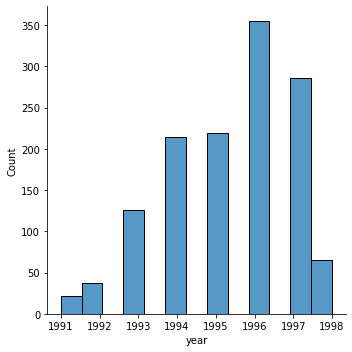

In [4]:
import seaborn as sns
sns.displot(items[items['year']>1990]['year'])